In [107]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../../lab_1/')

from functions import (
    get_portfolio_expected_return,
    get_portfolio_std,
    solve_risk_aversion,
    get_random_portfolios,
    get_VaR,
)

import financedatabase as fd

from typing import List
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.simplefilter(action='ignore', category=RuntimeWarning)

PATH_TO_DATA = "../../lab_1/data/data_with_return.csv"
SEED = 404

In [2]:
TOKEN = "yfj4hxcXAyB6RdR3NuQcI0NhJD6fqTW6"
NUM_STOCKS = 50

equities = fd.Equities().search(exchange="MCX")
equities = equities.rename(index=lambda s: s[:-3])
equities = equities[["name", "sector"]]

df = pd.read_csv(PATH_TO_DATA, encoding='UTF-16')
df = df.set_index('SECID').join(equities, how="left")
df = df.drop(set(df[df.name.isna()].index))

stocks_50 = df.groupby(by=["SECID"])\
    .agg({"VOLUME": "median"})\
    .sort_values(by="VOLUME", ascending=False)\
    .head(NUM_STOCKS).index
df = df.loc[stocks_50]

df["SECID"] = df.index
df = df.reset_index(drop=True)

In [78]:
df.head(1)

,TRADEDATE,NUMTRADES,LEGALCLOSEPRICE,CLOSE,VOLUME,TRENDCLSPR,RETURN,name,sector,SECID
0,2018-01-03,17019,0.0495,0.0495,17351060000,4.61,0.0,VTB Bank (public joint-stock company),Financials,VTBR


In [3]:
mu = df.groupby(by="SECID", as_index=False)\
    .agg({"RETURN": "mean"})\
    .rename(columns={"RETURN": "MEAN"})\
    .sort_values(by="SECID")\
    ["MEAN"]\
    .to_numpy()

new_df = dict()
for stock in df["SECID"].unique():
    stock_returns = df[df["SECID"] == stock].sort_values(by="TRADEDATE")["RETURN"].to_list()
    new_df[stock] = stock_returns
new_df = pd.DataFrame(new_df)
new_df = new_df.sort_index(axis=1)

sigma = new_df.cov().values

### С запретом коротких продаж

In [22]:
risk_aversion = [0.5, 1, 2, 4, 10]

solutions_dict = {"mean": [], "std": [], "risk_aversion": risk_aversion, "type": ["risk_aversion"]*len(risk_aversion)}
solution_weights = []
for aversion in risk_aversion:
    solution = solve_risk_aversion(mu, sigma, aversion)
    solutions_dict["mean"].append(solution["expected_return"])
    solutions_dict["std"].append(solution["risk"])
    solution_weights.append(pd.DataFrame({"weights": solution["weights"]}, index=df.SECID.sort_values().unique()))

In [9]:
NUM_RANDOM_PORTFOLIO = 100
SEED = 18
N = df.SECID.nunique()
np.random.seed(SEED)

random_portfolio_df = get_random_portfolios(df, random_samples=NUM_RANDOM_PORTFOLIO)
solutions = pd.DataFrame(solutions_dict)

equal_ratios = [1/N]*N
equal_expected_return = get_portfolio_expected_return(df, equal_ratios)
equal_std = get_portfolio_std(df, equal_ratios)
min_portfolio = random_portfolio_df[random_portfolio_df.type == "not_short_sales"].sort_values(by="std").head(1)

equal_portfolio = pd.DataFrame({"mean": [equal_expected_return], "std": [equal_std], "type": ["equal_portfolio"]})
index_portfolio = pd.DataFrame({"mean": [0.000377], "std": [0.010814], "type": ["index_portfolio"]})
min_portfolio = pd.DataFrame({"mean": min_portfolio["mean"], "std": min_portfolio["std"], "type": ["min_portfolio"]})
risk_aversion_portfolio = solutions[["mean", "std", "type"]]

portfolio_df = pd.concat([random_portfolio_df, equal_portfolio, index_portfolio, min_portfolio, risk_aversion_portfolio])

In [10]:
def get_df_by_type(df: pd.DataFrame, types_name: List):
    return df[df.type.isin(types_name)]

custom_palette = {
    "with_short_sales": "#FF8C00",
    "not_short_sales": "#00BFFF",
    "equal_portfolio": "#FF0000",
    "index_portfolio": "#00FF00",
    "min_portfolio": "#000000",
    "min_portfolio_short": "#000000",
    "risk_aversion": "#362FD9",
}

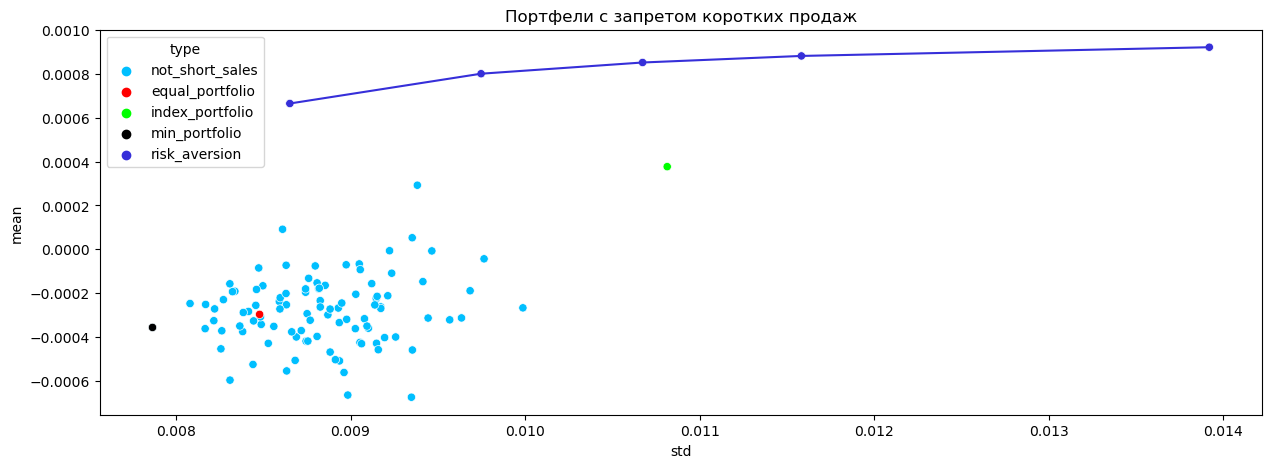

In [11]:
plt.figure(figsize=(15, 5))

types_name = ["not_short_sales", "equal_portfolio", "index_portfolio", "min_portfolio", "risk_aversion"]
sns.scatterplot(data=get_df_by_type(portfolio_df, types_name), x="std", y="mean", hue="type", palette=custom_palette);
plt.plot(solutions["std"], solutions["mean"], c=custom_palette["risk_aversion"])
plt.title("Портфели с запретом коротких продаж");

In [72]:
aversion_df = solution_weights[-1]
main_stocks = aversion_df[aversion_df.weights > 0.011].sort_values(by="weights", ascending=False)
main_stocks = main_stocks.join(equities, how="left")
other_stocks = pd.DataFrame({"weights": 1 - main_stocks.weights.sum(), "sector": "Other"}, index=["Other"])

In [73]:
main_stocks

,weights,name,sector
NVTK,0.165887,PAO NOVATEK,Energy
TATN,0.103741,PJSC Tatneft,Energy
SNGSP,0.101393,Surgutneftegas Public Joint Stock Company,Energy
ROSN,0.079666,Public Joint Stock Company Rosneft Oil Company,Energy
DVEC,0.062747,Public joint stock company FAR-EASTERN ENERGY ...,Utilities
RTKM,0.046568,Public Joint Stock Company Rostelecom,Communication Services


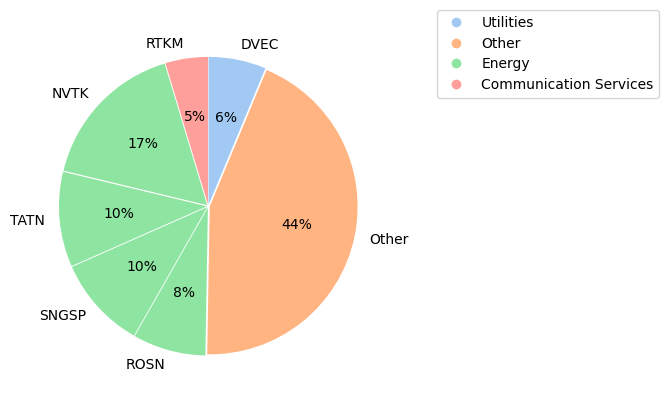

In [80]:
all_stocks = pd.concat([main_stocks, other_stocks])
sectors = all_stocks["sector"].values

colors = sns.color_palette('pastel')[0:len(sectors)]
colors_dict = dict()
for i, sector in enumerate(set(sectors)):
    colors_dict[sector] = colors[i]

plt.pie(
    all_stocks.sort_values(by="sector").weights,
    labels = all_stocks.sort_values(by="sector").index, 
    colors = all_stocks.sort_values(by="sector")["sector"].map(colors_dict), 
    autopct='%.0f%%',
    startangle=90, 
    explode=[0.01] * len(sectors)
    )

# The following two lines generate custom fake lines that will be used as legend entries:
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors_dict.values()]
plt.legend(markers, colors_dict.keys(), numpoints=1, bbox_to_anchor=(1.1, 1.05))

plt.show()

In [116]:
stocks_expected_return = df.groupby(by="SECID").agg({"RETURN": "mean"}).sort_index()
gamma = 0.95
VaR = get_VaR(stocks_expected_return["RETURN"] * aversion_df.weights, gamma)
print(f"Возможные потери:{VaR:0.5f}")

Возможные потери:0.00002


### Короткие продажи разрешены

In [81]:
risk_aversion = [4, 5, 6, 7, 10]

solutions_dict_short = {"mean": [], "std": [], "risk_aversion": risk_aversion, "type": ["risk_aversion"]*len(risk_aversion)}
solution_weights_short = []
for aversion in risk_aversion:
    solution = solve_risk_aversion(mu, sigma, aversion, with_short=True)
    solutions_dict_short["mean"].append(solution["expected_return"])
    solutions_dict_short["std"].append(solution["risk"])
    solution_weights_short.append(pd.DataFrame({"weights": solution["weights"]}, index=df.SECID.sort_values().unique()))

In [82]:
NUM_RANDOM_PORTFOLIO = 100
SEED = 18
np.random.seed(SEED)
N = df.SECID.nunique()

random_portfolio_df = get_random_portfolios(df, random_samples=NUM_RANDOM_PORTFOLIO, with_short=True)
solutions_short = pd.DataFrame(solutions_dict_short)

min_portfolio_short = random_portfolio_df[random_portfolio_df.type == "with_short_sales"].sort_values(by="std").head(1)
min_portfolio_short = pd.DataFrame({"mean": min_portfolio_short["mean"], "std": min_portfolio_short["std"], "type": ["min_portfolio_short"]})
risk_aversion_portfolio_short = solutions_short[["mean", "std", "type"]]

portfolio_df = pd.concat([random_portfolio_df, min_portfolio_short, risk_aversion_portfolio_short])

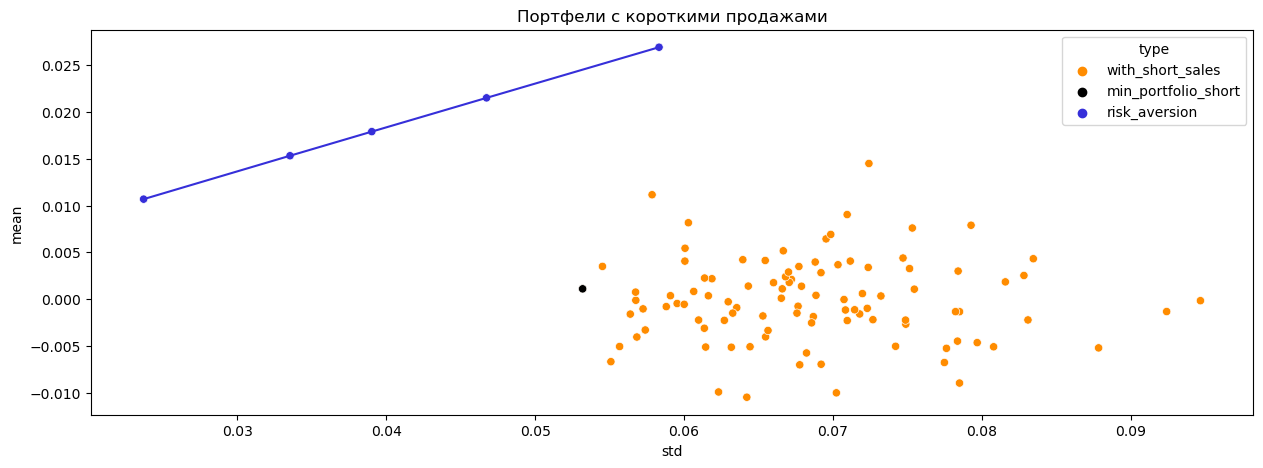

In [84]:
plt.figure( figsize=(15, 5))
types_name = ["with_short_sales", "min_portfolio_short", "risk_aversion"]
sns.scatterplot(data=get_df_by_type(portfolio_df, types_name), x="std", y="mean", hue="type", palette=custom_palette);
plt.plot(solutions_short["std"], solutions_short["mean"], c=custom_palette["risk_aversion"]);
plt.title("Портфели с короткими продажами");

In [87]:
aversion_df_short = solution_weights_short[-1]
main_stocks_short = aversion_df_short.sort_values(by="weights", ascending=False)
main_stocks_short = main_stocks_short.join(equities, how="left")

In [119]:
stocks_expected_return = df.groupby(by="SECID").agg({"RETURN": "mean"}).sort_index()
gamma = 0.95
VaR = get_VaR(stocks_expected_return["RETURN"] * aversion_df_short.weights, gamma)
print(f"Возможные потери:{VaR:0.5f}")

Возможные потери:0.00009


In [117]:
positive_df = main_stocks_short[main_stocks_short.weights > 0].head(2)
positive_df

,weights,name,sector
RTKM,0.978904,Public Joint Stock Company Rostelecom,Communication Services
CBOM,0.897067,Credit Bank of Moscow (public joint-stock comp...,Financials


In [118]:
negative_df = main_stocks_short[main_stocks_short.weights < 0].tail(2)
negative_df

,weights,name,sector
HYDR,-0.643400,Public Joint-Stock Company Federal Hydro-Gener...,Utilities
MSRS,-0.650107,Public Joint-Stock Company Rosseti Moscow Region,Utilities
